# Agent-Based Simulation: Best-Response Dynamics
 

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import random 
import pandas as pd
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np
from scipy import optimize as opt
from scipy import integrate as intg
from scipy.optimize import least_squares
from scipy.stats import beta
from scipy.stats import bernoulli
from scipy.stats import cumfreq, beta
from utils import Agent

%matplotlib inline
plt.style.use('../notebook.mplstyle')

SEED = 1 

## Exogenous Parameters


In [2]:
# Setting exogenous parameters
def reset_exog_params():
    global Bm, Bw, bm_vals, bw_vals, δ, Um, Uw, Fm, Fw, λm, λw
    Bm = 10
    Bw = 10
    bm_vals = range(1,Bm+1) 
    bw_vals = range(1,Bw+1)
    
    δ = 0.97
    Um = lambda θ : θ 
    Uw = lambda θ : θ
    Fm = beta(3,3)
    Fw = beta(3,3)
    λm = 10
    λw = 10

def exog_params():
    return (Bm, Bw, bm_vals, bw_vals, δ, Um, Uw, Fm, Fw, λm, λw)

## Steady State Equilibrium Conditions


In [3]:
# Optimality conditions
def SSE(x): 
    # Endogenous Variables 
    μ = x[:Bm] 
    ω = x[Bm:Bm+Bw]   

    Pm = x[Bm+Bw:2*Bm+Bw]
    Pw = x[2*Bm+Bw:2*Bm+2*Bw]  

    Nm = x[2*Bm+2*Bw] 
    Nw = x[2*Bm+2*Bw+1]  
    
    τm = min(Nw/Nm, 1)
    τw = τm * (Nm/Nw) 
    αm = (τm*δ)/(1-δ*(1-τm))
    αw = (τw*δ)/(1-δ*(1-τw)) 

    # Initialising system of equilibrium equations
    E = np.empty(2*Bm + 2*Bw + 2) 

    # Initial condition for men 
    E[0] = (Um(μ[0]) 
            - αm * Um(μ[0]) * Fw.cdf(μ[0]) 
            - αm * intg.quad(lambda t: Um(t) * Fw.pdf(t), μ[0], 1)[0]) 
    
    # Intertemporal optimality conditions for men
    for b in range(1, Bm):
        E[b] = (Um(μ[b]) 
                - αm * Um(μ[b]) * Fw.cdf(μ[b]) 
                - αm * Um(μ[b-1])*(1-Fw.cdf(μ[b-1])) 
                - αm * intg.quad(lambda t : Um(t) * Fw.pdf(t), μ[b], μ[b-1])[0])
    
    # Initial condition for women     
    E[Bm] = (Uw(ω[0]) 
            - αw * Uw(ω[0]) * Fm.cdf(ω[0]) 
            - αw * intg.quad(lambda t: Uw(t) * Fm.pdf(t), ω[0], 1)[0])

    # Intertemporal optimality conditions for women
    for b in range(1, Bw):
        E[Bm+b] = (Uw(ω[b]) 
                - αw * Uw(ω[b]) * Fm.cdf(ω[b]) 
                - αw * Uw(ω[b-1])*(1-Fm.cdf(ω[b-1])) 
                - αw * intg.quad(lambda t : Uw(t) * Fm.pdf(t), ω[b], ω[b-1])[0]) 
                
    # Platform flow men
    E[Bm+Bw] = λm - (1-δ)*Nm - Nm*Pm[0]*δ*τm*(1-Fw.cdf(μ[0]))

    for b in range(0, Bm-1):
       E[Bm+Bw+b+1] = (Nm*Pm[b+1]*δ*τm*(1-Fw.cdf(μ[b+1]))
                    - Nm*Pm[b]*(1-δ) - Nm*Pm[b]*δ*τm*(1-Fw.cdf(μ[b])))

    E[2*Bm+Bw] = λm - Nm*Pm[Bm-1]*(1-δ) - Nm*Pm[Bm-1]*δ*τm*(1-Fw.cdf(μ[Bm-1]))

    # Platform flow women
    E[2*Bm+Bw+1] = λw - (1-δ)*Nw - Nw*Pw[0]*δ*τw*(1-Fm.cdf(ω[0]))  

    for b in range(0, Bw-1):
       E[2*Bm+Bw+2+b] = (Nw*Pw[b+1]*δ*τw*(1-Fm.cdf(ω[b+1]))
                      - Nw*Pw[b]*(1-δ) - Nw*Pw[b]*δ*τw*(1-Fm.cdf(ω[b])))

    E[2*Bm+2*Bw+1] = λw - Nw*Pw[Bw-1]*(1-δ) - Nw*Pw[Bw-1]*δ*τw*(1-Fm.cdf(ω[Bw-1])) 

    return E 

## Balanced Steady State Equilibria Computation


In [4]:
reset_exog_params()
λm = 10
λw = 10
μ_test = np.random.rand(Bm) 
ω_test = np.random.rand(Bw) 

Pm_test = np.random.rand(Bm)
Pw_test = np.random.rand(Bw) 

N_test = np.array([λm*(Bm+1), λw*(Bw+1)])

print('μ0: ', μ_test)
print('ω0: ', ω_test)
print('')

x_start = np.concatenate((μ_test, ω_test, Pm_test, Pw_test, N_test), axis=None) 
solution = opt.root(SSE, x_start) 

μ0:  [0.88906359 0.46037095 0.9951904  0.72150336 0.67250418 0.96508051
 0.82897583 0.43375901 0.60059147 0.62883064]
ω0:  [0.96848036 0.83683885 0.79730764 0.53959222 0.76241493 0.17247906
 0.23011066 0.7218729  0.12679409 0.05047439]



In [6]:
μ_star = solution.x[:Bm]
ω_star = solution.x[Bm:Bm+Bw]
loss = round(np.sum(SSE(solution.x)**2), 3)
print('μ* ', μ_star) 
print('ω* ', ω_star) 
print('Loss: ',loss) 
print('')

Pm = solution.x[Bm+Bw:2*Bm+Bw]
Pw = solution.x[2*Bm+Bw:2*Bm+2*Bw]  

ss_Nm_b = solution.x[2*Bm+2*Bw] 
ss_Nw_b = solution.x[2*Bm+2*Bw+1]

# Normalized masses 
nm = [(Pm[b]*ss_Nm_b)/(ss_Nm_b+ss_Nw_b) for b in range(Bm)]
nw = [(Pw[b]*ss_Nw_b)/(ss_Nm_b+ss_Nw_b) for b in range(Bw)]

print('Masses: ', round((ss_Nm_b)/(ss_Nm_b+ss_Nw_b),3), 
                  round((ss_Nw_b)/(ss_Nm_b+ss_Nw_b),3))
print('Unity Sum check:', round(sum(Pm),3), round(sum(Pw),3))
print('')

τm = min(ss_Nw_b/ss_Nm_b, 1)
τw = τm * (ss_Nm_b/ss_Nw_b) 
αm = (τm*δ)/(1-δ*(1-τm))
αw = (τw*δ)/(1-δ*(1-τw)) 
print('Tightness: ', round(τm,3), round(τw,3))
print('Alphas: ', round(αm,3), round(αw,3)) 
print('')

ρm = sum([(1 - Fw.cdf(μ_star[b]))*Pm[b] for b in range(Bm)])
ρw = sum([(1 - Fm.cdf(ω_star[b]))*Pw[b] for b in range(Bw)])
print('Average Swipe Rate: ', round(ρm, 3), round(ρw, 3))

μ*  [0.66366994 0.59515949 0.54890106 0.51301625 0.4833236  0.45781311
 0.43534878 0.41521996 0.3969497  0.38020096]
ω*  [0.66366994 0.59515949 0.54890106 0.51301625 0.4833236  0.45781311
 0.43534878 0.41521996 0.3969497  0.38020096]
Loss:  0.0

Masses:  0.5 0.5
Unity Sum check: 1.0 1.0

Tightness:  1 1.0
Alphas:  0.97 0.97

Average Swipe Rate:  0.491 0.491


## Best-Response Computation


In [7]:
# Optimality conditions
def BestResponse(x, Nm, Nw): 
    μ = x[:Bm] 
    ω = x[Bm:] 
    τm = min(Nw/Nm, 1)
    τw = τm * (Nm/Nw) 
    αm = (τm*δ)/(1-δ*(1-τm))
    αw = (τw*δ)/(1-δ*(1-τw))  
    
    # Initialising system of equilibrium equations
    E = np.empty(Bm+Bw)
    
    # Initial conditions 
    E[0] = (Um(μ[0]) 
            - αm * Um(μ[0]) * Fw.cdf(μ[0]) 
            - αm * intg.quad(lambda t: Um(t) * Fw.pdf(t), μ[0], 1)[0]) 
    
    E[Bm] = (Uw(ω[0]) 
            - αw * Uw(ω[0]) * Fm.cdf(ω[0]) 
            - αw * intg.quad(lambda t: Uw(t) * Fm.pdf(t), ω[0], 1)[0]) 
    
    # Intertemporal optimality conditions for men
    for b in range(1,Bm):
        E[b] = (Um(μ[b]) 
                - αm * Um(μ[b]) * Fw.cdf(μ[b]) 
                - αm * Um(μ[b-1])*(1-Fw.cdf(μ[b-1])) 
                - αm * intg.quad(lambda t : Um(t) * Fw.pdf(t), μ[b], μ[b-1])[0])
    
    # Intertemporal optimality conditions for women
    for b in range(1,Bw):
        E[Bm+b] = (Uw(ω[b]) 
                - αw * Uw(ω[b]) * Fm.cdf(ω[b]) 
                - αw * Uw(ω[b-1])*(1-Fm.cdf(ω[b-1])) 
                - αw * intg.quad(lambda t : Uw(t) * Fm.pdf(t), ω[b], ω[b-1])[0]) 
        
    return E 

## Myopic Best-Response Dynamics

In [8]:
def simulate_MBR(T, μ0, ω0, batch=0): 
    simulation = [] 
    men = []
    women = []  
    for t in range(0,T):
        # Compute agent best-responses
        if t==0:
            μt = μ0
            ωt = ω0
        else: 
            Nm = len(men)
            Nw = len(women) 
            x_start = np.random.rand(Bm + Bw)
            solution = least_squares(BestResponse, x_start, args=(Nm, Nw), 
                                     bounds = (0,1), verbose=1) 
            μt = solution.x[:Bm]
            ωt = solution.x[Bm:]
            print('')
            print(f'Loss @t={t}:', round(solution.cost,6)) 

        # Update strategies
        for m in men:
            m.rule = μt

        for w in women:
            w.rule = ωt    

        # Add new agents 
        for i, θ in enumerate(Fm.rvs(size=λm)): 
            men.append(Agent(t*λm + i, t, 'Male', θ, Bm, μt))
        
        for i, θ in enumerate(Fw.rvs(size=λw)): 
            women.append(Agent(t*λw + i, t, 'Female', θ, Bw, ωt))  
        
        # Gameplay 
        random.shuffle(men)
        random.shuffle(women)  
        pairs = zip(men, women) 

        for m, w in pairs: 
            am = m.swipe(w, t)
            aw = w.swipe(m, t)
            m.update(am, aw, t)
            w.update(aw, am, t) 

        # Logging    
        for agent in (men + women): 
            simulation.append(agent.info(batch, t))  
                
        # Departures
        m_dpts = bernoulli.rvs((1-δ), size=len(men)) 
        w_dpts = bernoulli.rvs((1-δ), size=len(women))
            
        men[:] = [m for i, m in enumerate(men) 
                  if (m.b != 0) and (m_dpts[i] == 0)]
        women[:] = [w for i, w in enumerate(women) 
                    if (w.b != 0) and (w_dpts[i] == 0)] 

    return simulation

## Single Batch Balanced Simulation

In [9]:
reset_exog_params()   
T = 120
μ0 = np.random.rand(Bm) 
ω0 = np.random.rand(Bw) 
simulation = simulate_MBR(T, μ0, ω0) 
b_batch = pd.DataFrame(simulation)
b_batch.head(5)

`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 2.9959e-01, final cost 1.2616e-22, first-order optimality 1.56e-12.

Loss @t=1: 0.0
`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 4.6119e-01, final cost 1.1154e-20, first-order optimality 1.46e-11.

Loss @t=2: 0.0
`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 3.3514e-01, final cost 5.4313e-25, first-order optimality 1.67e-13.

Loss @t=3: 0.0
`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 7.4880e-01, final cost 2.3279e-15, first-order optimality 6.68e-09.

Loss @t=4: 0.0
`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 7.0605e-01, final cost 2.5345e-16, first-order optimality 3.90e-09.

Loss @t=5: 0.0
`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 6.6951e-01, final cost 5.9828e-17, first-order optimality 1.08e-09.

Loss @t=6: 0.0
`gtol` terminati

,batch,id,time,birth,sex,attractiveness,budget,observed_rate,true_rate,matches,rs_given,rs_received
0,0,8,0,0,Male,0.651941,9,1.0,1.0,1,1,1
1,0,5,0,0,Male,0.374274,9,1.0,1.0,1,1,1
2,0,9,0,0,Male,0.686225,9,1.0,1.0,1,1,1
3,0,7,0,0,Male,0.362246,9,1.0,1.0,1,1,1
4,0,6,0,0,Male,0.511287,9,1.0,1.0,1,1,1


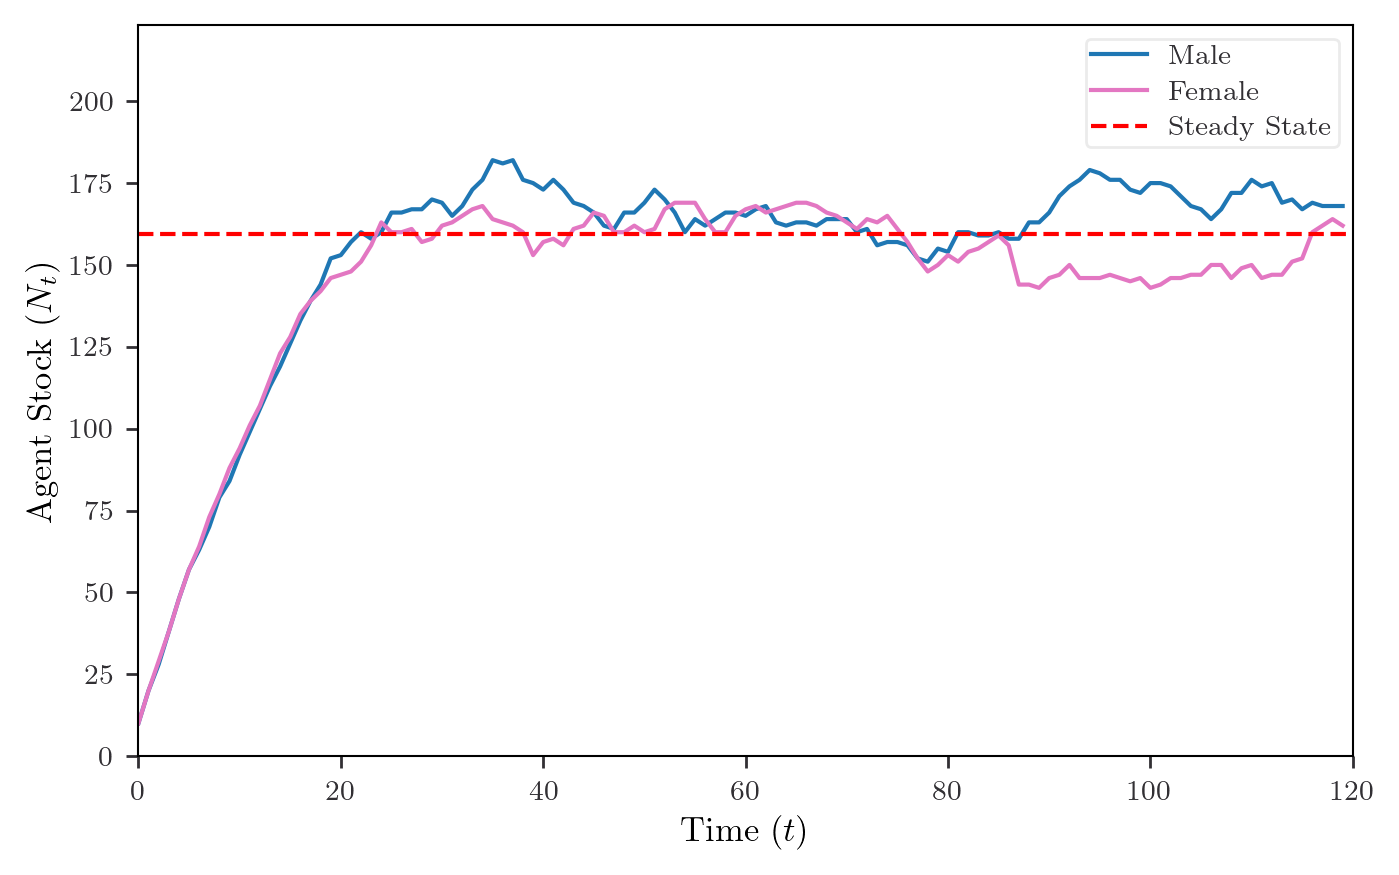

In [11]:
mass_by_sex = b_batch.groupby(['time', 'sex'], as_index=False).size() 
Nm_series = mass_by_sex[mass_by_sex.sex=='Male']['size']
Nw_series = mass_by_sex[mass_by_sex.sex=='Female']['size']

fig, ax = plt.subplots()
ax.set_xlim(0,T)
ax.set_ylim(0, 1.4*max(ss_Nm_b, ss_Nw_b))  
ax.plot(range(0,T), Nm_series, color='tab:blue', label='Male') 
ax.plot(range(0,T), Nw_series, color='tab:pink', label='Female') 

ax.axhline(y=ss_Nm_b, color='r', linestyle='--', label='Steady State') 

ax.set(xlabel=r'Time ($t$)', ylabel=r'Agent Stock ($N_t$)')
ax.legend()
#plt.savefig('../../figures/abm-br-balanced.png', bbox_inches='tight')
plt.show() 

## Unbalanced Steady State Equilibria Computation


In [12]:
reset_exog_params()
# Setting unbalanced arrival flows
λm = 20
λw = 10

μ_test = np.random.rand(Bm) 
ω_test = np.random.rand(Bw) 

Pm_test = np.random.rand(Bm)
Pw_test = np.random.rand(Bw) 

N_test = np.array([λm*(Bm+1), λw*(Bw+1)])

print('μ0: ', μ_test)
print('ω0: ', ω_test)
print('')

x_start = np.concatenate((μ_test, ω_test, Pm_test, Pw_test, N_test), axis=None) 
solution = opt.root(SSE, x_start) 

μ0:  [0.0915091  0.6888951  0.10473729 0.48490828 0.77740359 0.22557431
 0.71977079 0.06925026 0.61529994 0.41107153]
ω0:  [0.81569426 0.00731302 0.01089323 0.19235411 0.39333473 0.6969682
 0.74553251 0.93446837 0.14307468 0.02838868]



In [13]:
μ_star = solution.x[:Bm]
ω_star = solution.x[Bm:Bm+Bw]
loss = round(np.sum(SSE(solution.x)**2), 3)
print('μ* ', μ_star) 
print('ω* ', ω_star) 
print('Loss: ',loss) 
print('')

Pm = solution.x[Bm+Bw:2*Bm+Bw]
Pw = solution.x[2*Bm+Bw:2*Bm+2*Bw]  

ss_Nm = solution.x[2*Bm+2*Bw] 
ss_Nw = solution.x[2*Bm+2*Bw+1]

# Normalized masses 
nm = [(Pm[b]*ss_Nm)/(ss_Nm+ss_Nw) for b in range(Bm)]
nw = [(Pw[b]*ss_Nw)/(ss_Nm+ss_Nw) for b in range(Bw)]

print('Masses: ', round((ss_Nm)/(ss_Nm+ss_Nw),3), round((ss_Nw)/(ss_Nm+ss_Nw),3))
print('Unity Sum check:', round(sum(Pm),3), round(sum(Pw),3))
print('')

τm = min(ss_Nw/ss_Nm, 1)
τw = τm * (ss_Nm/ss_Nw) 
αm = (τm*δ)/(1-δ*(1-τm))
αw = (τw*δ)/(1-δ*(1-τw)) 
print('Tightness: ', round(τm,3), round(τw,3))
print('Alphas: ', round(αm,3), round(αw,3)) 
print('')

ρm = sum([(1 - Fw.cdf(μ_star[b]))*Pm[b] for b in range(Bm)])
ρw = sum([(1 - Fm.cdf(ω_star[b]))*Pw[b] for b in range(Bw)])
print('Average Swipe Rate: ', round(ρm, 3), round(ρw, 3))

μ*  [0.56258451 0.47202629 0.41132631 0.36474793 0.32672713 0.29458043
 0.26678558 0.24238559 0.22073373 0.2013686 ]
ω*  [0.66366994 0.59515949 0.54890106 0.51301625 0.4833236  0.45781311
 0.43534878 0.41521996 0.3969497  0.38020096]
Loss:  0.0

Masses:  0.744 0.256
Unity Sum check: 1.0 1.0

Tightness:  0.345 1.0
Alphas:  0.918 0.97

Average Swipe Rate:  0.774 0.491


## Single Batch Unbalanced Simulation

In [14]:
T = 120
μ0 = np.random.rand(Bm) 
ω0 = np.random.rand(Bw) 
simulation = simulate_MBR(T, μ0, ω0) 
ub_batch = pd.DataFrame(simulation)
ub_batch.head(5)

`gtol` termination condition is satisfied.
Function evaluations 9, initial cost 5.8285e-01, final cost 6.1166e-26, first-order optimality 3.40e-14.

Loss @t=1: 0.0
`gtol` termination condition is satisfied.
Function evaluations 7, initial cost 6.3873e-01, final cost 5.8329e-17, first-order optimality 9.53e-10.

Loss @t=2: 0.0
`gtol` termination condition is satisfied.
Function evaluations 7, initial cost 7.5681e-01, final cost 7.7555e-18, first-order optimality 3.65e-10.

Loss @t=3: 0.0
`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 6.2285e-01, final cost 7.5063e-17, first-order optimality 1.20e-09.

Loss @t=4: 0.0
`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 4.6218e-01, final cost 8.2306e-19, first-order optimality 1.52e-10.

Loss @t=5: 0.0
`gtol` termination condition is satisfied.
Function evaluations 7, initial cost 2.9724e-01, final cost 4.7806e-21, first-order optimality 1.65e-11.

Loss @t=6: 0.0
`gtol` terminati

,batch,id,time,birth,sex,attractiveness,budget,observed_rate,true_rate,matches,rs_given,rs_received
0,0,5,0,0,Male,0.757736,9,1.0,1.0,0,1,0
1,0,2,0,0,Male,0.560496,9,1.0,1.0,0,1,0
2,0,4,0,0,Male,0.729150,9,1.0,1.0,0,1,0
3,0,14,0,0,Male,0.570951,9,1.0,1.0,0,1,0
4,0,11,0,0,Male,0.490654,9,1.0,1.0,0,1,0


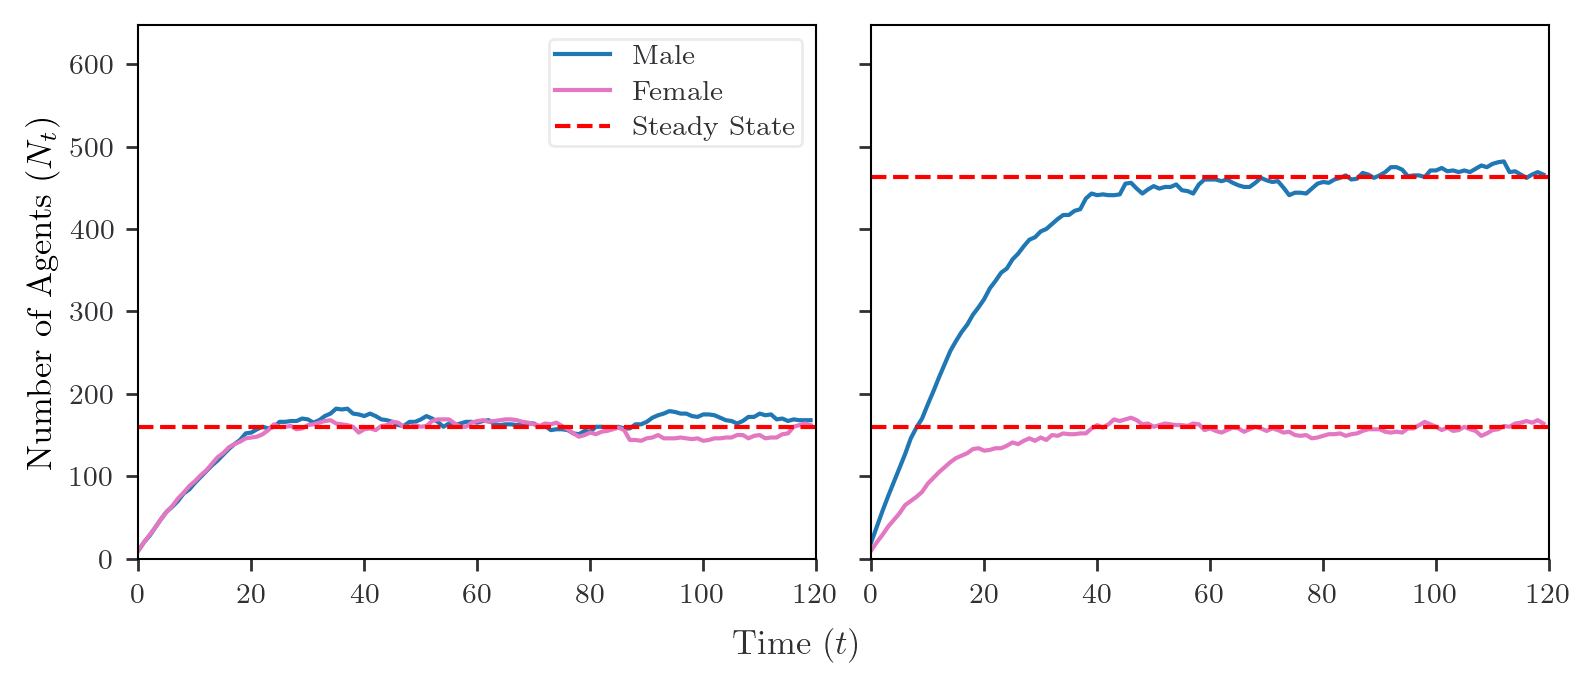

In [20]:
mass_b = b_batch.groupby(['time', 'sex'], as_index=False).size() 
mass_ub = ub_batch.groupby(['time', 'sex'], as_index=False).size() 

Nm_b = mass_b[mass_by_sex.sex=='Male']['size']
Nw_b = mass_b[mass_by_sex.sex=='Female']['size']

Nm_ub = mass_ub[mass_by_sex.sex=='Male']['size']
Nw_ub = mass_ub[mass_by_sex.sex=='Female']['size']

fig, axs = plt.subplots(1,2, figsize=(6.267704441677044, 2.6368271881975483), constrained_layout=True, sharey=True)
axs[0].set_xlim(0,T)
axs[1].set_xlim(0,T) 

axs[0].set_ylim(0, 1.4*max(ss_Nm_b, ss_Nw_b))
axs[1].set_ylim(0, 1.4*max(ss_Nm, ss_Nw))

axs[0].plot(range(0,T), Nm_b, color='tab:blue', label='Male') 
axs[0].plot(range(0,T), Nw_b, color='tab:pink', label='Female') 
axs[1].plot(range(0,T), Nm_ub, color='tab:blue', label='Male') 
axs[1].plot(range(0,T), Nw_ub, color='tab:pink', label='Female') 

axs[0].axhline(y=ss_Nm_b, color='r', linestyle='--', label='Steady State') 
axs[1].axhline(y=ss_Nm, color='r', linestyle='--', label='Steady State')
axs[1].axhline(y=ss_Nw, color='r', linestyle='--', label='Steady State')

axs[0].legend()  

axs[0].set(ylabel=r'Number of Agents ($N_t$)')
fig.supxlabel('Time ($t$)', size=10) 

plt.savefig('../../figures/abm-br.png', bbox_inches='tight')
plt.show() 